In [ ]:
import os
import torch
import torchvision
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
import torchvision.models as models
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torchvision.datasets.folder import default_loader
from IPython.display import Image 
from tqdm.notebook import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
!pip install jovian --upgrade --quiet
import jovian
%matplotlib inline

In [ ]:
batch_size = 128
image_size = (512,512)
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
transform_ds = transforms.Compose([transforms.Resize(image_size),
                                   transforms.ToTensor(),
                                   transforms.Normalize(*stats)
                                   ])

train_ds = torchvision.datasets.ImageFolder(root="/content/drive/MyDrive/resized",
                                     transform=transform_ds)

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
print(len(train_ds))

8683


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 512, 512])


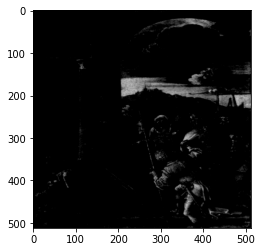

In [ ]:
images,_ = train_ds[182]
print(images.size())
plt.imshow(images.permute(1,2,0))

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

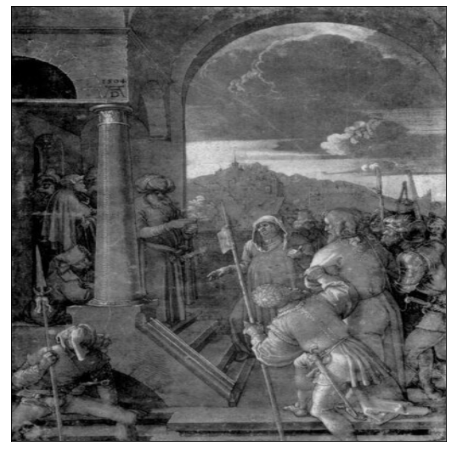

In [ ]:
show_images(images)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


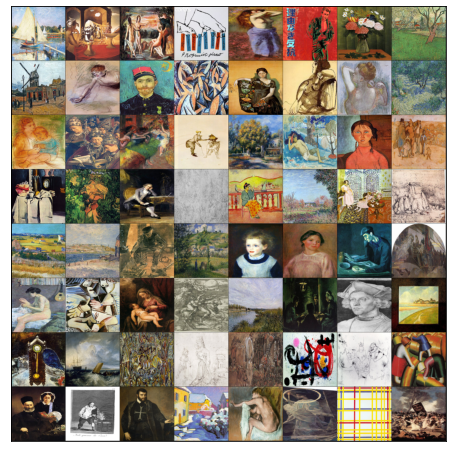

In [ ]:
show_batch(train_dl)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

In [ ]:
discriminator = nn.Sequential(

    nn.Conv2d(3, 8, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(8),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(8, 16, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(16),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),

    
    nn.Sigmoid())


In [ ]:
# discriminator = nn.Sequential(
#     # in: 3 x 64 x 64

#     nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(64),
#     nn.LeakyReLU(0.2, inplace=True),
#     # out: 64 x 32 x 32

#     nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(128),
#     nn.LeakyReLU(0.2, inplace=True),
#     # out: 128 x 16 x 16

#     nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(256),
#     nn.LeakyReLU(0.2, inplace=True),
#     # out: 256 x 8 x 8

#     nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(512),
#     nn.LeakyReLU(0.2, inplace=True),
#     # out: 512 x 4 x 4

#     nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
#     # out: 1 x 1 x 1

#     nn.Flatten(),
#     nn.Sigmoid())

In [ ]:
discriminator = to_device(discriminator, device)

In [ ]:
latent_size = 150

In [ ]:
generator = nn.Sequential(

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.ReLU(True),

    nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(16),
    nn.ReLU(True),

    nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(8),
    nn.ReLU(True),

    nn.ConvTranspose2d(8, 3, kernel_size=4, stride=2, padding=1, bias=False),
    
)

In [ ]:
# generator = nn.Sequential(
#     # in: latent_size x 1 x 1

#     nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
#     nn.BatchNorm2d(512),
#     nn.ReLU(True),
#     # out: 512 x 4 x 4

#     nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(256),
#     nn.ReLU(True),
#     # out: 256 x 8 x 8

#     nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(128),
#     nn.ReLU(True),
#     # out: 128 x 16 x 16

#     nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(64),
#     nn.ReLU(True),
#     # out: 64 x 32 x 32

#     nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.Tanh()
#     # out: 3 x 64 x 64
# )

torch.Size([128, 3, 512, 512])


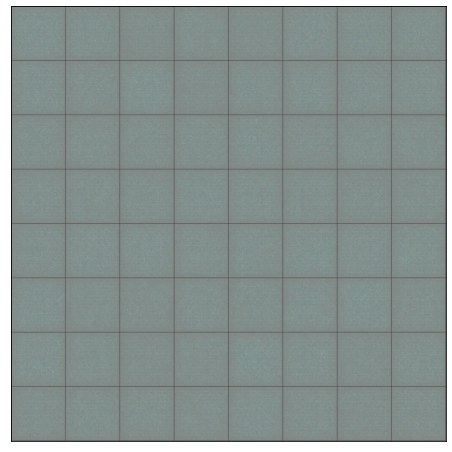

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [ ]:
generator = to_device(generator, device)

In [ ]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [ ]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [ ]:
from torchvision.utils import save_image


In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


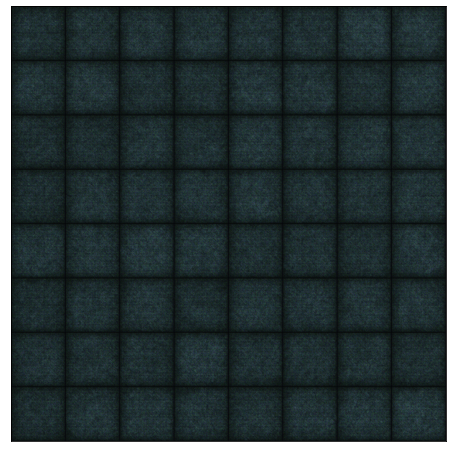

In [ ]:
save_samples(0, fixed_latent)

In [ ]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
jovian.commit(project="GANS high dimensional images", environment=None)

[jovian] Detected Colab notebook...


[jovian] Error: jovian.commit doesn't work on Colab unless the notebook was created and executed from Jovian.
Make sure to run the first code cell at the top after executing from Jovian.
Alternatively, you can download this notebook and upload it manually to Jovian.
Learn more: https://jovian.ai/docs/user-guide/run.html#run-on-colab


In [ ]:
lr = 0.001
epochs = 30

In [ ]:
jovian.reset()
jovian.log_hyperparams(lr=lr, epochs=epochs)

[jovian] Hyperparams logged.


In [ ]:
history = fit(epochs,lr)

  0%|          | 0/68 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [1/30], loss_g: 4.0626, loss_d: 0.1766, real_score: 0.9408, fake_score: 0.1004
Saving generated-images-0001.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [2/30], loss_g: 3.7737, loss_d: 0.3667, real_score: 0.7925, fake_score: 0.0688
Saving generated-images-0002.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [3/30], loss_g: 4.3354, loss_d: 0.0474, real_score: 0.9933, fake_score: 0.0395
Saving generated-images-0003.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [4/30], loss_g: 1.7655, loss_d: 1.4704, real_score: 0.7436, fake_score: 0.6200
Saving generated-images-0004.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [5/30], loss_g: 1.7048, loss_d: 0.8085, real_score: 0.6644, fake_score: 0.2972
Saving generated-images-0005.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [6/30], loss_g: 1.1362, loss_d: 1.0966, real_score: 0.5312, fake_score: 0.3209
Saving generated-images-0006.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [7/30], loss_g: 6.4212, loss_d: 1.6606, real_score: 0.3064, fake_score: 0.0049
Saving generated-images-0007.png


  0%|          | 0/68 [00:00<?, ?it/s]

In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
jovian.log_metrics(loss_g=losses_g[-1], 
                   loss_d=losses_d[-1], 
                   real_score=real_scores[-1], 
                   fake_score=fake_scores[-1])

[jovian] Metrics logged.


In [ ]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.ckpt')
torch.save(discriminator.state_dict(), 'D.ckpt')

Text(0.5, 1.0, 'Losses')

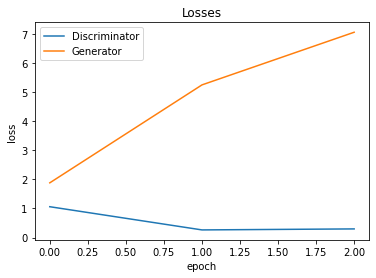

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses')

Text(0.5, 1.0, 'Scores')

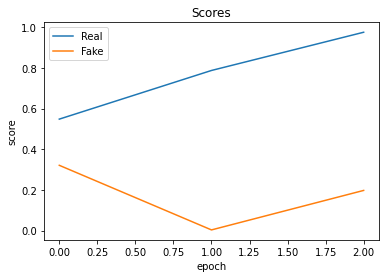

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores')